In [1]:
from config import *
from encoder import *
from data import *
from clip import *
from eval import *
from augmentor import *
from describer import *
print("using device: ", device)
random_state = 333
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# for debugging
# import importlib
# import models
# importlib.reload(models)


Random seed set to 333


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


using device:  cpu


In [2]:
# ---- update configs ----
overwrite = False
model_name = 'clip_hr_death_raw'
text_config['cl']['die7d'] = True # udpate text_config here if needed
model_name = model_name + "___" + "_".join(get_true_components(text_config))
txt_ls = ['will die', 'will survive']

update_config(
    model_name = model_name,
    ts_aug = False,
    ts_normalize = False,
    ts_encode = False,
    balance = False,
    block_target = False,
    txt_ls = txt_ls,
    patience = 20,
    num_saves = 20,
    num_epochs = 100,
    text_config = text_config
)
config_dict = get_config_dict()
config_dict

{'device': 'cpu',
 'batch_size': 128,
 'text_encoder_name': 'sentence-transformers/all-mpnet-base-v2',
 'ts_encoder_name': 'hr_vae_linear_medium',
 'ts_aug': False,
 'ts_normalize': False,
 'ts_encode': False,
 'block_target': False,
 'balance': False,
 'model_name': 'clip_hr_death_raw___die7d_ga_bwt_sumb_simple_succ_inc_histogram',
 'embedded_dim': 128,
 'init_lr': 0.0001,
 'patience': 20,
 'num_saves': 20,
 'num_epochs': 100,
 'loss_type': 'block_diagonal',
 'txt_ls': ['will die', 'will survive'],
 'text_config': {'cl': {'die7d': True, 'fio2': False},
  'demo': {'ga_bwt': True, 'gre': False, 'apgar_mage': False},
  'ts': {'sumb': True,
   'sumd': False,
   'simple': True,
   'full': False,
   'event1': False,
   'succ_inc': True,
   'histogram': True}}}

In [3]:
# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = gen_text_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = gen_text_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64
This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  No Bradycardia events.   Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64
This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  No Bradycardia events.  It shows high variability.  Low amount of consecutive increases. 


In [4]:
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
y_col = 'cl_event'
# ---- downsample negative class(es) ----
# sample 5000 rows from df_test[df_test[y_col]==txt_ls_org[1]], without replacement
neg_sample_size = 5000
df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False)
df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False)
df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])


# ---- augment + balance train data----
target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
max_size = int(target_event_rate*len(df_train))
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    txt_ls_org, 
                                    y_col, 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth', 
                                    K=10,
                                    max_size=max_size)


# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    df_train['label'] = df_train['rowid'].astype(int)
    df_test['label'] = df_test['rowid'].astype(int)

def get_y_true_and_ts_df(df_new, txt_ls_org):
    df_new_y = pd.get_dummies(df_new['cl_event'])
    df_new_y = df_new_y[txt_ls_org]
    y_true = torch.tensor(df_new_y.values)
    ts_df = df_new.loc[:,'1':'300']
    return y_true, ts_df

y_true_train, ts_df_train = get_y_true_and_ts_df(df_train, txt_ls_org)     # create y_true_train and ts_df_train
y_true_test, ts_df_test = get_y_true_and_ts_df(df_test, txt_ls_org)     # create y_true_test and ts_df_test
print(ts_df_train.shape)
print(ts_df_test.shape)

(5384, 300)
(5241, 300)


# Main Usage

In [5]:
# ---- ready encoded dataloaders ---- 
def check_data_ready():
    required_objects = {
        'y_true_train': (pd.DataFrame, np.ndarray, torch.Tensor),
        'ts_df_train': pd.DataFrame,
        'y_true_test': (pd.DataFrame, np.ndarray, torch.Tensor),
        'ts_df_test': pd.DataFrame,
        'txt_ls': list
    }
    
    for obj_name, expected_type in required_objects.items():
        # Check if object exists in globals
        if obj_name not in globals():
            raise ValueError(f"Missing required object: {obj_name}")
        
        obj = globals()[obj_name]
        # Check if object is None
        if obj is None:
            raise ValueError(f"Object {obj_name} is None")
            
        # Check type
        if not isinstance(obj, expected_type):
            raise TypeError(f"{obj_name} should be of type {expected_type}, but got {type(obj)}")
        
        # Check if empty
        if hasattr(obj, '__len__') and len(obj) == 0:
            raise ValueError(f"{obj_name} is empty")

    print("✓ All required objects are properly defined and non-empty")
    return True
try:
    check_data_ready()
except Exception as e:
    print(f"Error: {e}")
    print("Please define all required objects before proceeding")


ts_f_train, tx_f_train, labels_train = get_features(df_train,config_dict['ts_encoder_name'], 
                                                    config_dict['text_encoder_name'], 
                                                    config_dict['ts_normalize'],
                                                    config_dict['ts_encode'])
train_dataloader = CLIPDataset(ts_f_train, tx_f_train, labels_train).dataloader(batch_size=config_dict['batch_size'])
ts_f_test, tx_f_test, labels_test = get_features(df_test, config_dict['ts_encoder_name'], 
                                                 config_dict['text_encoder_name'], 
                                                 config_dict['ts_normalize'],
                                                 config_dict['ts_encode'])
test_dataloader = CLIPDataset(ts_f_test, tx_f_test, labels_test).dataloader(batch_size=config_dict['batch_size'])


✓ All required objects are properly defined and non-empty


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
# ---- ready data storage ---- 
import shutil
if overwrite:
    # remove the subfolder './results/'+model_name
    if os.path.exists('./results/'+model_name):
        shutil.rmtree('./results/'+model_name)
    overwrite = False # reset overwrite to False

if not os.path.exists('./results/'+model_name):
    os.makedirs('./results/'+model_name)
model_path = './results/'+model_name+'/model.pth' 
eval_path = './results/'+model_name+'/evals.pth'
config_path = './results/'+model_name+'/config.pth'
if not os.path.exists(config_path):
    torch.save(config_dict, config_path)

# ---- ready model ----
ts_dim = TSFeature(df_train.loc[:1,'1':'300'], config_dict['ts_encoder_name'], 
                                                 config_dict['ts_normalize'],
                                                 config_dict['ts_encode']).features.shape[1]
tx_dim= TXTFeature(['test'],config_dict['text_encoder_name']).features.shape[1]
model = CLIPModel(
        ts_dim=ts_dim,
        text_dim=tx_dim,
        output_dim=config_dict['embedded_dim']
    )
optimizer = torch.optim.AdamW(model.parameters(), lr=config_dict['init_lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=config_dict['patience'],          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)
train_eval_metrics_list = []
test_eval_metrics_list = []
train_losses = []
test_losses = []

/Users/joyqiu/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Layer (type:depth-idx)                                       Param #
CLIPModel                                                    1
├─Sequential: 1-1                                            --
│    └─Linear: 2-1                                           38,528
│    └─BatchNorm1d: 2-2                                      256
│    └─LeakyReLU: 2-3                                        --
│    └─Dropout: 2-4                                          --
│    └─ResidualBlock: 2-5                                    --
│    │    └─Sequential: 3-1                                  66,688
│    │    └─LeakyReLU: 3-2                                   --
│    └─ResidualBlock: 2-6                                    --
│    │    └─Sequential: 3-3                                  66,688
│    │    └─LeakyReLU: 3-4                                   --
│    └─ResidualBlock: 2-7                                    --
│    │    └─Sequential: 3-5                                  132,992
│    │    └─LeakyR

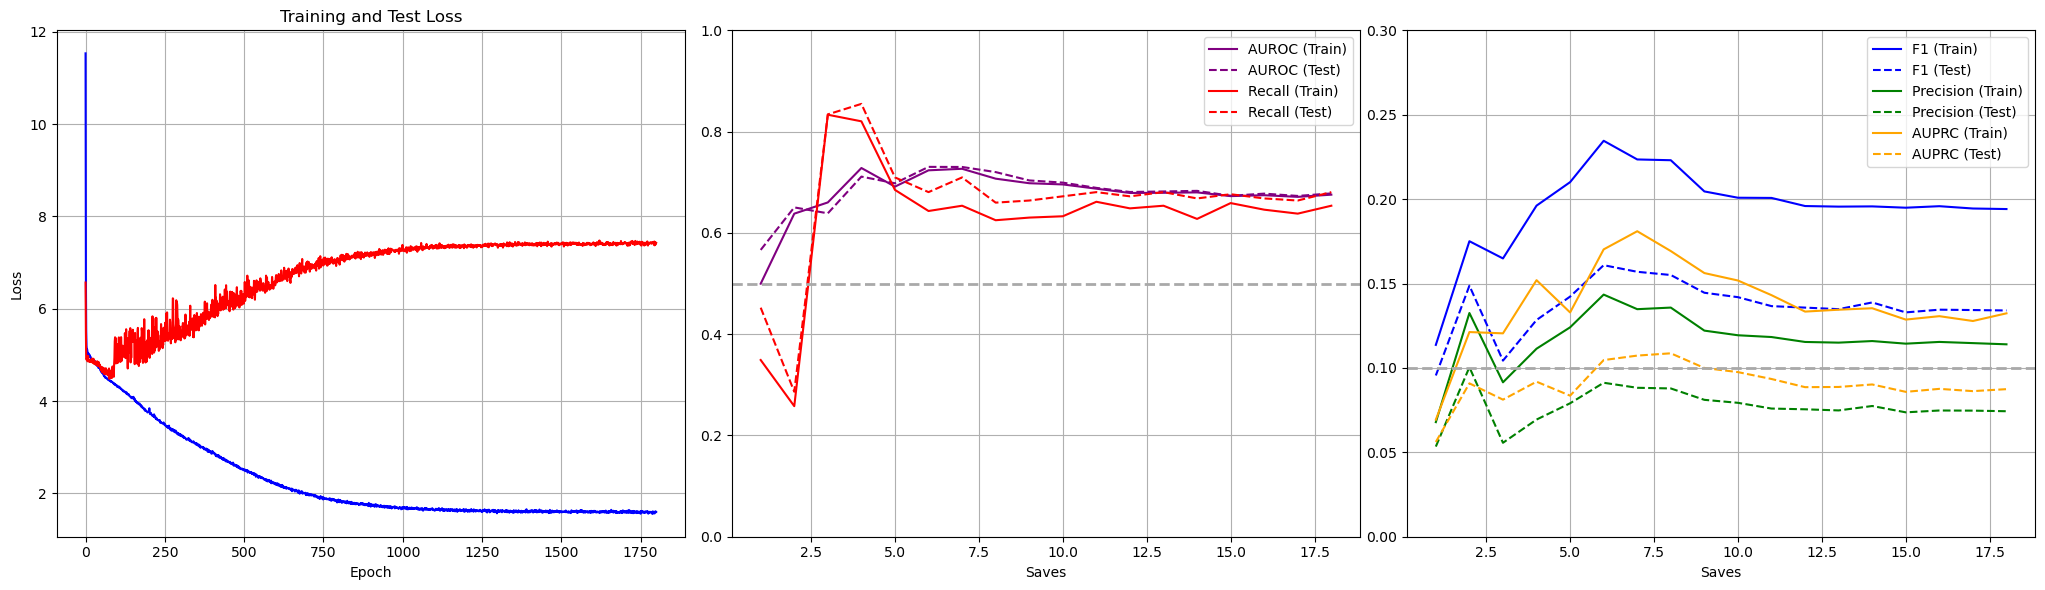

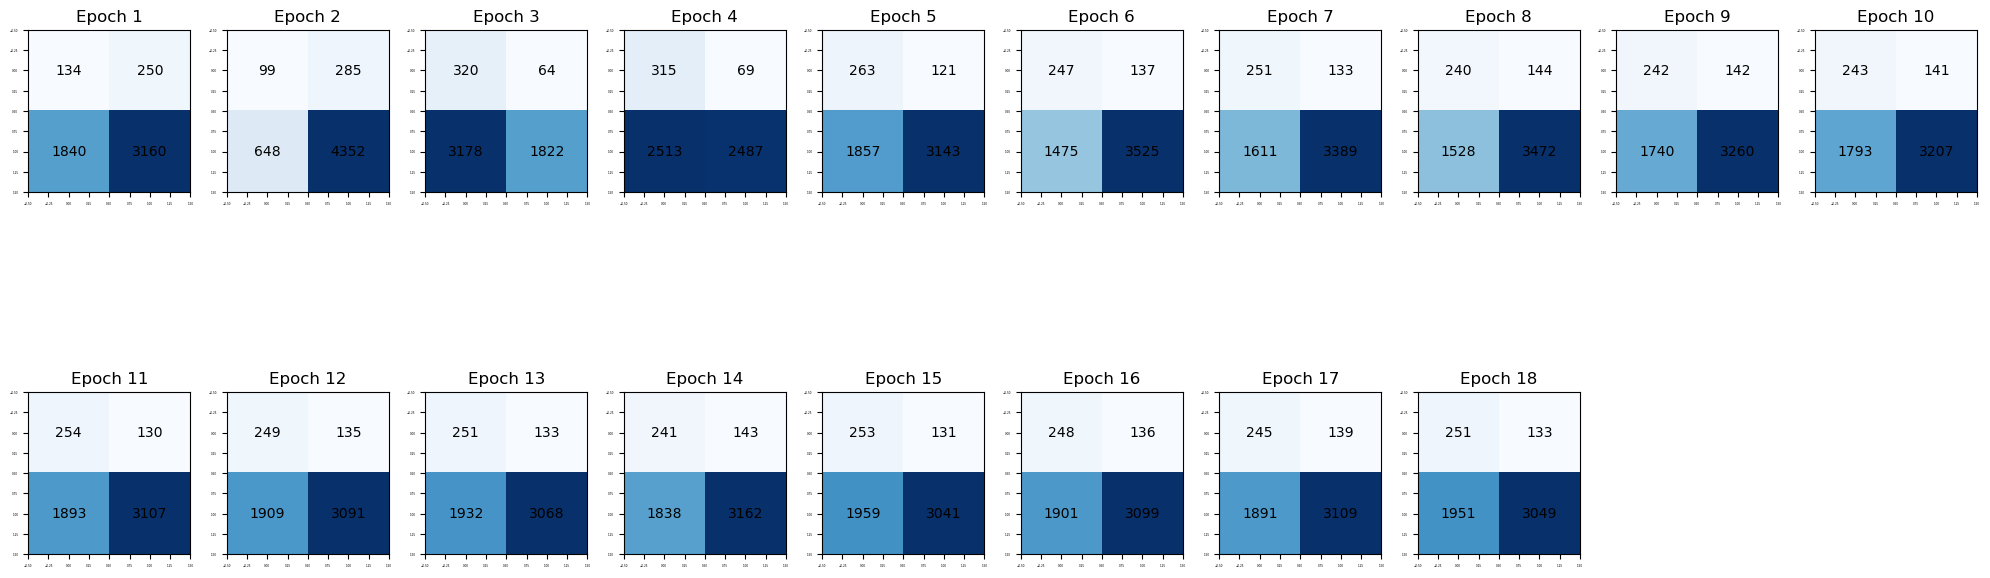

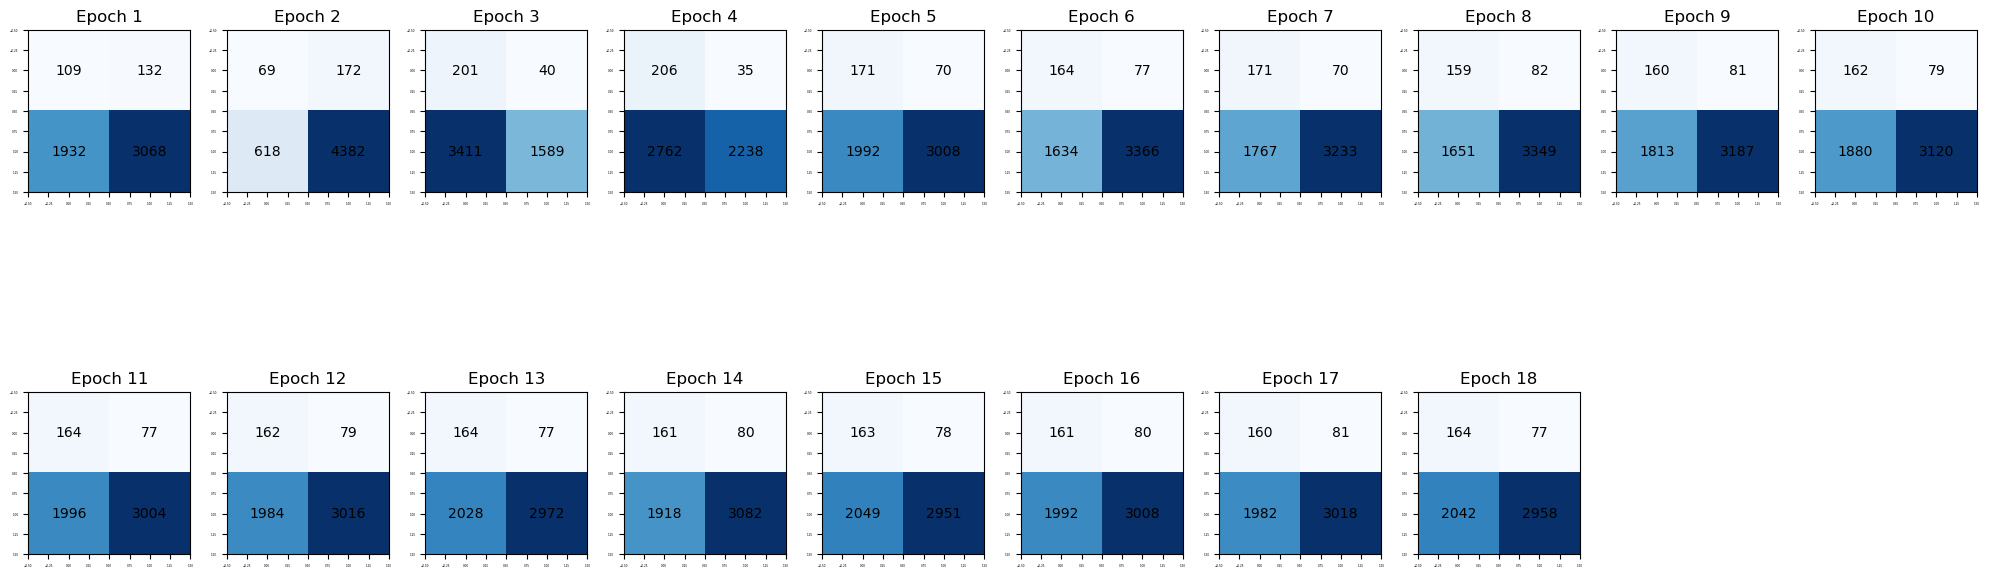

In [26]:
if overwrite or not os.path.exists(model_path):
    
    for i in range(config_dict['num_saves']): 
        train_losses_tmp, test_losses_tmp = train(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                config_dict['num_epochs'], 
                                                device,
                                                config_dict['loss_type'])
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        train_eval_metrics = eval_model(model, y_true_train, ts_df_train, config_dict['txt_ls'], 
                                        config_dict['ts_encoder_name'], config_dict['text_encoder_name'],
                                        config_dict['ts_normalize'], config_dict['ts_encode'])
        test_eval_metrics = eval_model(model, y_true_test, ts_df_test, config_dict['txt_ls'], 
                                       config_dict['ts_encoder_name'], config_dict['text_encoder_name'],
                                       config_dict['ts_normalize'], config_dict['ts_encode'])
        train_eval_metrics_list.append(train_eval_metrics)
        test_eval_metrics_list.append(test_eval_metrics)
        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_evals': train_eval_metrics_list,
            'test_evals': test_eval_metrics_list }, eval_path)
        # if i % 10 == 0: # every 10 saves, evaluate the model
        eval_dict = torch.load(eval_path)
        eval_dict_eng = eng_eval_metrics(eval_dict, binary=True)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)
    
else:
    model.load_state_dict(torch.load(model_path))
    eval_dict = torch.load(eval_path)
    train_losses = eval_dict['train_losses']
    test_losses = eval_dict['test_losses']
    train_eval_metrics_list = eval_dict['train_evals']
    test_eval_metrics_list = eval_dict['test_evals']
    eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot_confusion_matrices=True)